# 

In [87]:
from roboflow import Roboflow
import supervision as sv
import cv2

rf = Roboflow(api_key="XFyqojATCHr8y2AZHABl")
project = rf.workspace().project("fire-and-smoke-segmentation")
model = project.version(3).model

image_path = "fire_val/val/000129.jpg"

result = model.predict(image_path, confidence=40).json()

labels = [item["class"] for item in result["predictions"]]

detections = sv.Detections.from_inference(result)

label_annotator = sv.LabelAnnotator()
mask_annotator = sv.MaskAnnotator()

image = cv2.imread(image_path)

annotated_image = mask_annotator.annotate(scene=image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections, labels=labels)

sv.plot_image(image=annotated_image, size=(16, 16))


loading Roboflow workspace...
loading Roboflow project...


AttributeError: type object 'Detections' has no attribute 'from_inference'

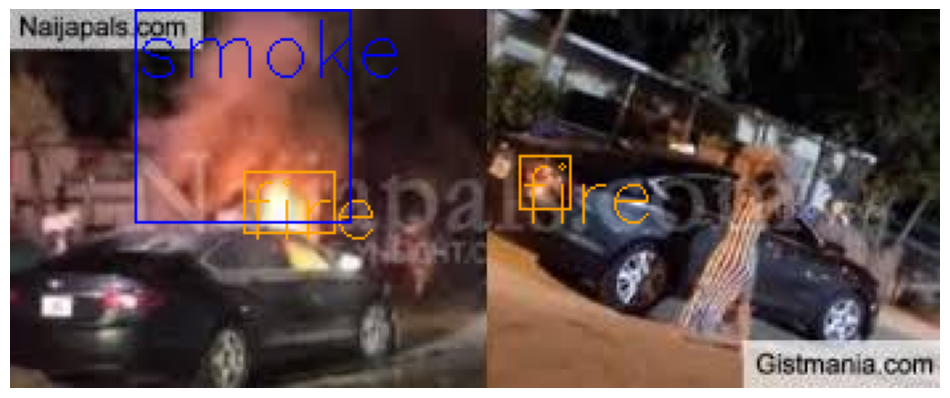

In [2]:
import json
import cv2
import matplotlib.pyplot as plt

with open('fire_train/instances_default.json') as f:
    templates = json.load(f)

ID_OF_IMAGE = 500
image_info = None
for item in templates["images"]:
    if item["id"] == ID_OF_IMAGE:
        image_info = item
        break
        
if image_info is None:
    print("Изображение с id=58 не найдено")
    exit()

image_path = "fire_train/" + image_info["file_name"]
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  

annotations = []
for item in templates["annotations"]:
    if item["image_id"] == ID_OF_IMAGE and item["category_id"] in [4, 5]:
        annotations.append(item)

for ann in annotations:
    bbox = ann["bbox"]  # [x, y, width, height]
    x, y, w, h = map(int, bbox)
    
    if ann["category_id"] == 4:
        color = (0, 0, 255)  
    else:
        color = (255, 165, 0) 
    
    cv2.rectangle(image, (x, y), (x + w, y + h), color, 1)

    if (ann["category_id"] == 4):
        cv2.putText(image, "smoke", (x, y + 25), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 1)
    else:
        cv2.putText(image, "fire", (x, y + 25), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 1)

plt.figure(figsize=(12, 8))
plt.imshow(image)
plt.axis('off')
plt.show()

In [19]:
import json
import os
from tqdm import tqdm

def coco_to_yolo(input_json, output_dir, target_categories):
    with open(input_json) as f:
        data = json.load(f)
    
    os.makedirs(output_dir, exist_ok=True)
    
    images = {img["id"]: img for img in data["images"]}
    
    processed_files = set()

    for ann in tqdm(data["annotations"]):
        if ann["category_id"] not in target_categories:
            continue
            
        img_info = images[ann["image_id"]]
        img_w = img_info["width"]
        img_h = img_info["height"]
        
        # Обрабатываем путь к файлу
        file_name = img_info["file_name"]
        base_name = os.path.splitext(os.path.basename(file_name))[0]
        relative_path = os.path.dirname(file_name)
        
        # Создаем целевую директорию
        target_dir = os.path.join(output_dir, relative_path)
        os.makedirs(target_dir, exist_ok=True)
        
        # Конвертация в YOLO формат
        x, y, w, h = ann["bbox"]
        x_center = (x + w/2) / img_w
        y_center = (y + h/2) / img_h
        w_norm = w / img_w
        h_norm = h / img_h
        
        line = f"{abs(ann['category_id']-5)} {x_center} {y_center} {w_norm} {h_norm}"
        
        txt_path = os.path.join(target_dir, f"{base_name}.txt")
        
        # Записываем в файл
        with open(txt_path, 'a') as f:
            f.write(line + '\n')
        
        processed_files.add(txt_path)

    for img in data["images"]:
        file_name = img["file_name"]
        base_name = os.path.splitext(os.path.basename(file_name))[0]
        relative_path = os.path.dirname(file_name)
        target_dir = os.path.join(output_dir, relative_path)
        txt_path = os.path.join(target_dir, f"{base_name}.txt")
        
        if txt_path not in processed_files:
            os.makedirs(target_dir, exist_ok=True)
            with open(txt_path, 'w') as f:
                pass
                
coco_to_yolo(
    input_json="fire_train/instances_default.json",
    output_dir="yolo_labels",
    target_categories={4, 5}
)

100%|████████████████████████████████████████████████████████████████████████████| 6433/6433 [00:00<00:00, 6961.37it/s]


In [20]:
from ultralytics import YOLO

model = YOLO('yolov8x.pt')  
results = model.train(
    data='fire_dataset1.yaml',    
    epochs=60,                  
    batch=16,                    
    imgsz=640,                   
    device=0,                    
    workers=4,                   
    name='large_dataset',    
    optimizer='SGD'
)


Ultralytics 8.3.107  Python-3.9.1 torch-2.2.0+cu121 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
engine\trainer: task=detect, mode=train, model=yolov8x.pt, data=fire_dataset1.yaml, epochs=60, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=4, project=None, name=large_dataset, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, lin

train: Scanning C:\Users\Alex\3D Objects\fire_dataset\labels\train.cache... 36837 images, 9046 backgrounds, 0 corrupt: 

WARNING  Box and segment counts should be equal, but got len(segments) = 2916, len(boxes) = 41109. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.



val: Scanning C:\Users\Alex\3D Objects\fire_dataset\labels\val.cache... 5200 images, 855 backgrounds, 0 corrupt: 100%|█

WARNING  Box and segment counts should be equal, but got len(segments) = 291, len(boxes) = 7370. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


Plotting labels to runs\detect\large_dataset\labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs\detect\large_dataset
Starting training for 60 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/60      22.2G      1.531       2.22      1.739         13        640: 100%|██████████| 2303/2303 [1:37:00<00:0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 163/163 [07:


                   all       5200       7370      0.555      0.385      0.415      0.214

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/60      22.9G      1.522      1.942      1.716         13        640: 100%|██████████| 2303/2303 [2:46:30<00:0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 163/163 [07:

                   all       5200       7370      0.539      0.378      0.406      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/60      22.6G      1.619      2.204      1.802         10        640: 100%|██████████| 2303/2303 [2:18:24<00:0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 163/163 [13:


                   all       5200       7370      0.517       0.35      0.356      0.166

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/60      22.9G      1.633      2.239       1.82          4        640: 100%|██████████| 2303/2303 [2:26:47<00:0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 163/163 [07:


                   all       5200       7370      0.552      0.384      0.412      0.213

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/60      22.9G      1.561      2.042      1.769         11        640: 100%|██████████| 2303/2303 [2:40:27<00:0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 163/163 [07:


                   all       5200       7370      0.635      0.442      0.497      0.256

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/60      22.9G      1.505      1.893      1.716          7        640: 100%|██████████| 2303/2303 [2:20:24<00:0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 163/163 [03:

                   all       5200       7370      0.656      0.447      0.517      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/60      22.6G      1.464      1.787      1.688         18        640: 100%|██████████| 2303/2303 [2:11:05<00:0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 163/163 [06:

                   all       5200       7370      0.626      0.493      0.544      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/60      22.8G      1.423      1.679      1.658          5        640: 100%|██████████| 2303/2303 [2:14:34<00:0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 163/163 [05:

                   all       5200       7370      0.653      0.497      0.561      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/60      22.9G      1.388        1.6       1.63          6        640: 100%|██████████| 2303/2303 [2:11:24<00:0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 163/163 [08:

                   all       5200       7370      0.693      0.533      0.596      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/60      22.9G      1.363       1.53      1.603         12        640: 100%|██████████| 2303/2303 [2:16:56<00:0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 163/163 [03:

                   all       5200       7370      0.678      0.551      0.608      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/60      22.6G      1.337       1.46      1.583          6        640: 100%|██████████| 2303/2303 [2:27:09<00:0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 163/163 [10:

                   all       5200       7370      0.704      0.563      0.629      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/60      22.9G      1.305      1.398      1.553          9        640: 100%|██████████| 2303/2303 [2:11:58<00:0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 163/163 [06:

                   all       5200       7370      0.718      0.558      0.633      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/60      22.9G      1.275      1.342      1.534         10        640: 100%|██████████| 2303/2303 [3:00:35<00:0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 163/163 [10:

                   all       5200       7370      0.726      0.573      0.648       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/60      22.9G      1.249      1.295      1.514          9        640: 100%|██████████| 2303/2303 [2:48:37<00:0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 163/163 [04:

                   all       5200       7370      0.726      0.584      0.658      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/60      22.6G      1.233       1.25      1.502          8        640: 100%|██████████| 2303/2303 [2:05:42<00:0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 163/163 [09:

                   all       5200       7370      0.726      0.598      0.669        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/60      22.9G      1.207      1.213       1.48          8        640: 100%|██████████| 2303/2303 [2:22:21<00:0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 163/163 [02:

                   all       5200       7370      0.729        0.6      0.672      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/60      22.9G      1.189      1.177       1.46         16        640: 100%|██████████| 2303/2303 [2:18:44<00:0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 163/163 [03:

                   all       5200       7370      0.748      0.602       0.68      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/60      22.9G      1.161      1.138      1.439         11        640: 100%|██████████| 2303/2303 [2:22:45<00:0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 163/163 [03:

                   all       5200       7370      0.763      0.601      0.688      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/60      22.6G      1.154      1.115      1.433         13        640: 100%|██████████| 2303/2303 [2:13:56<00:0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 163/163 [05:

                   all       5200       7370      0.753      0.617      0.694      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/60      22.9G      1.129      1.082      1.419         11        640: 100%|██████████| 2303/2303 [2:26:25<00:0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 163/163 [03:

                   all       5200       7370       0.77      0.604      0.695       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/60      22.9G      1.112      1.046      1.396         18        640: 100%|██████████| 2303/2303 [2:38:23<00:0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 163/163 [04:

                   all       5200       7370      0.778      0.605      0.699      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/60      22.9G      1.092      1.019      1.387         10        640: 100%|██████████| 2303/2303 [3:19:18<00:0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 163/163 [03:

                   all       5200       7370      0.771      0.613      0.701      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/60      22.6G      1.079     0.9893      1.409         24        640:   1%|          | 15/2303 [01:13<3:07:33,


KeyboardInterrupt: 

In [57]:
from ultralytics import YOLO
model = YOLO('runs/detect/large_dataset/weights/best.pt') #ИЗМЕНИТЬ
metrics = model.val()



Ultralytics 8.3.107  Python-3.9.1 torch-2.2.0+cu121 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
Model summary (fused): 112 layers, 68,125,494 parameters, 0 gradients, 257.4 GFLOPs


val: Scanning C:\Users\Alex\3D Objects\fire_dataset\labels\val.cache... 5200 images, 855 backgrounds, 0 corrupt: 100%|█

WARNING  Box and segment counts should be equal, but got len(segments) = 291, len(boxes) = 7370. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 325/325 [03:


                   all       5200       7370      0.772      0.612      0.702      0.436
                  fire       3482       5242      0.784      0.698      0.761      0.452
                 smoke       1358       2128      0.759      0.527      0.643      0.421
Speed: 0.1ms preprocess, 39.7ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs\detect\val2


In [88]:
model = YOLO('runs/detect/large_dataset/weights/best.pt')
results = model.predict('тестовое6.jpg')
results[0].show()


image 1/1 C:\Users\Alex\3D Objects\6.jpg: 480x640 1 fire, 1 smoke, 44.7ms
Speed: 1.0ms preprocess, 44.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


In [89]:
from ultralytics import YOLO
import cv2
import numpy as np

model = YOLO('runs/detect/large_dataset/weights/best.pt')

results = model.predict('тестовое6.jpg')

detected_classes = set(int(box.cls) for box in results[0].boxes)
invert_labels = len(detected_classes) == 2 

names_to_use = model.names.copy()
if invert_labels:
    names_to_use = {
        0: 'fire' if model.names[0] == 'smoke' else 'smoke',
        1: 'smoke' if model.names[1] == 'fire' else 'fire'
    }

img = results[0].orig_img.copy()
for box in results[0].boxes:
    x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
    class_id = int(box.cls)
    
    label = names_to_use[class_id]
    color = (0, 0, 255) if label == 'fire' else (255, 0, 0)  
    
    cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
    cv2.putText(img, label, (x1, y1 + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

output_path = 'result_with_conditional_inversion.jpg'
cv2.imwrite(output_path, img)
print(f"Изображение сохранено как: {output_path}")


image 1/1 C:\Users\Alex\3D Objects\6.jpg: 480x640 1 fire, 1 smoke, 55.4ms
Speed: 1.0ms preprocess, 55.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)
Изображение сохранено как: result_with_conditional_inversion.jpg


In [23]:
import torch, platform, torchvision
import numpy as np
print(np.__version__) 
print(np.core)  
print("PyTorch:", torch.__version__)
print("CUDA:", torch.version.cuda)
print("ОС:", platform.platform())
print("Видеокарта:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "Не найдена")
print(f"PyTorch: {torch.__version__}")          # Должно быть 2.2.0
print(f"Torchvision: {torchvision.__version__}") # Должно быть 0.17.0
print(torch.cuda.is_available())                # Должно быть True

1.26.4
<module 'numpy.core' from 'c:\\users\\alex\\appdata\\local\\programs\\python\\python39\\lib\\site-packages\\numpy\\core\\__init__.py'>
PyTorch: 2.2.0+cu121
CUDA: 12.1
ОС: Windows-10-10.0.19041-SP0
Видеокарта: NVIDIA GeForce RTX 3060
PyTorch: 2.2.0+cu121
Torchvision: 0.17.0+cu121
True


In [2]:
#pip install torch==2.2.0+cu121 torchvision==0.17.0+cu121 torchaudio==2.2.0 --extra-index-url https://download.pytorch.org/whl/cu121

In [ ]:
#pip install "numpy<2"

In [7]:
#pip show ultralytics

In [22]:
#pip install ultralytics 

In [21]:
#pip install numpy==1.26.4

In [20]:
#pip show numpy